# DMPC study - norm objective

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.dmpc_norm import NormDMPC

### Platoon parameters

In [3]:
H = 20    # planning horizon
N = 7     # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 6.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
taus = [None, 0.51, 0.75, 0.78, 0.70, 0.73, 0.72, 0.62]
dyns = [None] + [LinearLong(dt, x_min, x_max, u_min, u_max, tau) for tau in taus[1:]]
n, m, p = dyns[1].n, dyns[1].m, dyns[1].p

# algorithm
n_pred = 1
neighbor_sets = [[] for _ in range(N+1)]
leader_sets = [[] for _ in range(N+1)]
info_sets = [[] for _ in range(N+1)]
dists_des = [[] for _ in range(N+1)]
Q = [None for _ in range(N+1)]
R = [None for _ in range(N+1)]
F = [None for _ in range(N+1)]
G = [None for _ in range(N+1)]
q, r, f, g = 10, 1, 10, 5

for i in range(1, N+1):
    neighbor_sets[i] = list(range(max(i-n_pred, 1), i))
    leader_sets[i] = [0] if i - n_pred <= 0 else []
    info_sets[i] = leader_sets[i] + neighbor_sets[i]
    for j in info_sets[i]:
        if j == 0:
            dists_des[i].append((i - j - 1)*d_des)
        else:
            dists_des[i].append((i - j)*d_des)
    Q[i] = q * np.eye(p) if 0 in info_sets[i] else np.zeros((p, p))
    R[i] = r * np.eye(m)
    F[i] = f * np.eye(p)
    G[i] = g * np.eye(p) if neighbor_sets[i] else np.zeros((p, p))
    # print(f"\nvehicle {i}:")
    # print(f"Q:\n {Q[i]}")
    # print(f"G:\n {G[i]}")
    # print(f"leader set: {leader_sets[i]}")
    # print(f"neighbor set: {neighbor_sets[i]}")
    # print(f"info set: {info_sets[i]}")
    # print(f"desired dists: {dists_des[i]}")

dmpc = [None] + \
    [NormDMPC(Q[i], R[i], F[i], G[i], dyns[1], x_min, x_max, u_min, u_max, H) 
     for i in range(1, N+1)]

### Reference trajectory - Acceleration

In [5]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

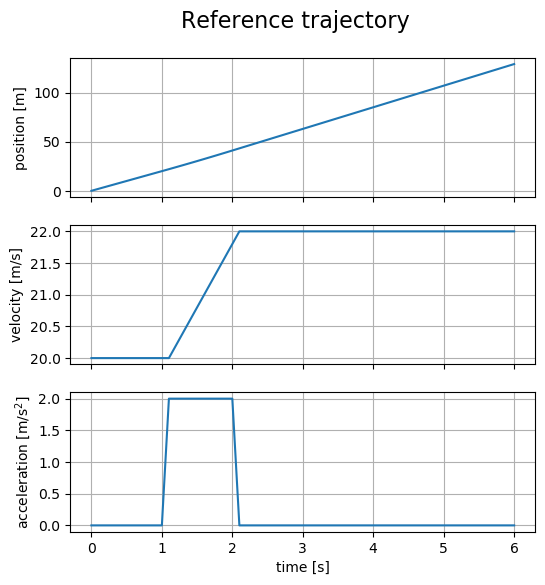

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)
for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

### Leader reference tracking

In [7]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
y_a_track = np.zeros((p, H + 1))
u_a_track = np.zeros((m, H))
x_a_track[:, 0] = x_track[:, 0]
y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
for k in range(H):
    x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])
    y_a_track[:, k+1] = dyns[1].sense(x_a_track[:, k+1])

In [8]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    y_a = y_a_track
    info_set = info_sets[1]
    y_i_a = [y_ref[:, k:k+H+1]]
    u_opt, x_opt, y_opt, value, status = dmpc[1].control(x_0, y_a, 
                                                         info_set, y_i_a, 
                                                         dists_des[1])
    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyns[1].forward(x_0, u_opt[:, 0])

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = np.zeros((m))
    x_a_track[:, 0] = x_opt[:, 1]
    y_a_track[:, 0] = dyns[1].sense(x_a_track[:, 0])
    for k in range(H):
        x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])
        y_a_track[:, k+1] = dyns[1].sense(x_a_track[:, k+1])

end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

  0%|          | 0/60 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-27


100%|██████████| 60/60 [00:07<00:00,  7.78it/s]


In [9]:
print(f"dmpc leader track avg rate: {1 / avg_time} s")

dmpc leader track avg rate: 7.904024685643985 s


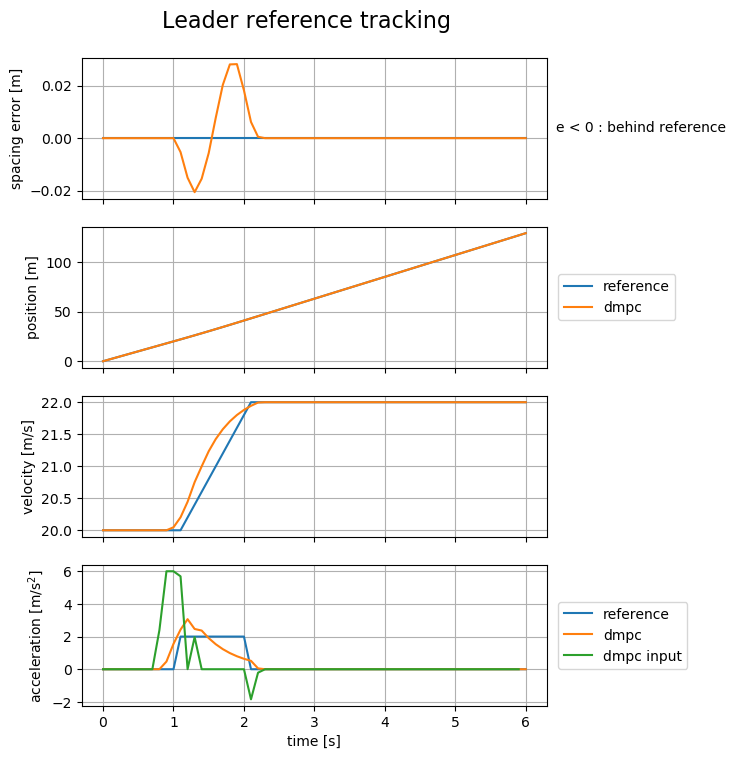

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], np.zeros(T-H), label="reference")
ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="dmpc")
ax[0].grid()
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', transform=ax[0].transAxes)
for i in range(1, x_ref.shape[0] + 1):
    ax[i].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")
    ax[i].grid()

ax[1].plot(t_range_mpc, x_track[0, :], label="dmpc")
ax[2].plot(t_range_mpc, x_track[1, :], label="dmpc")
ax[3].plot(t_range_mpc, x_track[2, :], label="dmpc")
ax[3].plot(t_range_mpc[:-1], u_track[0, :], label="dmpc input")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("position [m]")
ax[2].set_ylabel("velocity [m/s]")
ax[3].set_ylabel(r"acceleration [m/s$^2$]")
ax[3].set_xlabel("time [s]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[3].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");

## DMPC platoon analysis

In [11]:
x_dmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
u_dmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_dmpc[0] = x_ref[:, :T-H]
u_dmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_dmpc[i][:, 0] = np.array([-(i-1)*d, x_dmpc[0][1, 0], x_dmpc[0][2, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_dmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
x_a_dmpc[0] = x_dmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_dmpc[i][:, 0] = x_dmpc[i][:, 0]

y_a_dmpc = [np.zeros((p, H + 1)) for _ in range(N + 1)]
y_a_dmpc[0] = x_dmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_dmpc[i][:, 0] = dyns[i].sense(x_a_dmpc[i][:, 0])

u_a_dmpc = [np.zeros((m, H)) for _ in range(N + 1)]
u_a_dmpc[0] = u_dmpc[0][:, :H]

for i in range(1, N+1):
    for k in range(H):
        x_a_dmpc[i][:, k+1] = dyns[i].forward(x_a_dmpc[i][:, k], u_a_dmpc[i][:, k])
        y_a_dmpc[i][:, k+1] = dyns[i].sense(x_a_dmpc[i][:, k+1])

x_a_dmpc_prev = copy.deepcopy(x_a_dmpc)
y_a_dmpc_prev = copy.deepcopy(y_a_dmpc)
u_a_dmpc_prev = copy.deepcopy(u_a_dmpc)

In [12]:
start_time = time.time()


for k in tqdm(range(T - H - 1)):
    for i in range(1, N+1):
        neighbor_inds = list(range(i-1, max(i-3, 0), -1))
        leader_access = Q[i].any()

        x_0 = x_dmpc[i][:, k]
        y_a = y_a_dmpc_prev[i]
        info_set = info_sets[i]
        y_i_a = [y_a_dmpc_prev[j] for j in info_set]
        d_i = dists_des[i]

        u_opt, x_opt, y_opt, value, status = dmpc[i].control(
            x_0, y_a, info_set, y_i_a, d_i
        )

        if status != 'optimal':
            raise

        u_dmpc[i][:, k] = u_opt[:, 0]
        x_dmpc[i][:, k+1] = dyns[i].forward(x_0, u_opt[:, 0])

        # update assumed state, control, input
        u_a_dmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_dmpc[i][:, H-1] = np.zeros((m))
        x_a_dmpc[i][:, 0] = x_opt[:, 1]
        y_a_dmpc[i][:, 0] = dyns[i].sense(x_a_dmpc[i][:, 0])
        for t in range(H):
            x_a_dmpc[i][:, t+1] = dyns[i].forward(x_a_dmpc[i][:, t], u_a_dmpc[i][:, t])
            y_a_dmpc[i][:, t+1] = dyns[i].sense(x_a_dmpc[i][:, t+1])
    
    x_a_dmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_dmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_dmpc[0] = x_ref[2, k+1:k+H+1].reshape((-1, H))

    x_a_dmpc_prev = copy.deepcopy(x_a_dmpc)
    y_a_dmpc_prev = copy.deepcopy(y_a_dmpc)
    u_a_dmpc_prev = copy.deepcopy(u_a_dmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (N * (T - H))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:53<00:00,  1.11it/s]


In [13]:
if status != 'optimal':
    print(f"timestep {k}, vehicle {i}, {status}")
    print(f"info set: {info_set}")
    print(f"y_i_a:\n{y_i_a}")
    print(f"d_i:\n{d_i}")
    fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
    fig.suptitle("Platoon tracking dynamics", size=16)
    ax[0].set_title(f"{n_pred}-predecessor follower")
    fig.subplots_adjust(top=0.88)
    for i in range(N + 1):
        ax[0].plot(t_range_mpc[:k], x_dmpc[i][0, :k], label=f"vehicle {i}")
        ax[1].plot(t_range_mpc[:k], x_dmpc[i][1, :k], label=f"vehicle {i}")
        ax[2].plot(t_range_mpc[:k], x_dmpc[i][2, :k], label=f"vehicle {i}")
        ax[3].plot(t_range_mpc[:k], u_dmpc[i][0, :k], label=f"vehicle {i}")
    ax[0].set_ylabel("position [m]")
    ax[1].set_ylabel("velocity [m/s]")
    ax[2].set_ylabel(r"acceleration [m/s$^2$]")
    ax[3].set_ylabel(r"input [m/s$^2$]")
    ax[3].set_xlabel("time [s]")
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()
    ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")


In [14]:
print(f"\ndmpc average rate: {1 / avg_time} s")


dmpc average rate: 7.932547982203224 s


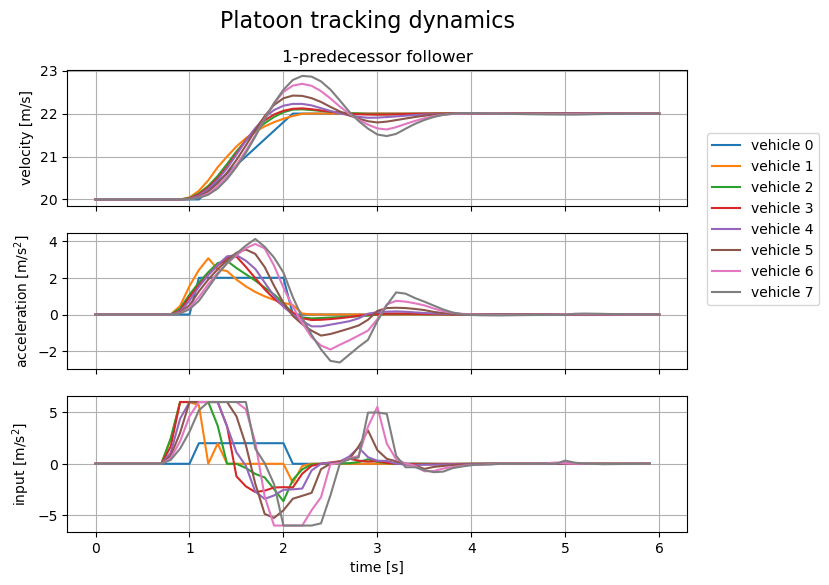

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"{n_pred}-predecessor follower")
fig.subplots_adjust(top=0.88)

for i in range(N + 1):
    ax[0].plot(t_range_mpc, x_dmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_dmpc[i][2, :], label=f"vehicle {i}")
    ax[2].plot(t_range_mpc[:-1], u_dmpc[i][0, :], label=f"vehicle {i}")

ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_ylabel(r"input [m/s$^2$]")
ax[2].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [16]:
d_error = [np.zeros(T-H) for _ in range(N + 1)]
v_error = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error[i] = x_dmpc[i][0, :] - x_dmpc[0][0, :] + d
    v_error[i] = x_dmpc[i][1, :] - x_dmpc[0][1, :]

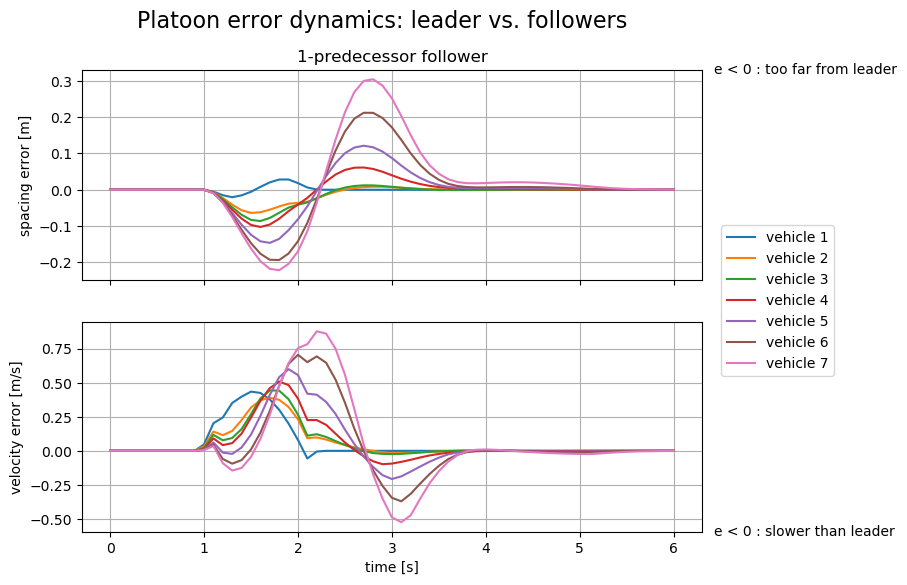

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"{n_pred}-predecessor follower")
fig.subplots_adjust(top=0.88)

for i in range(1, N+1):
    ax[0].plot(t_range[:T-H], d_error[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

In [18]:
d_error = [np.zeros(T-H) for _ in range(N + 1)]
v_error = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error[i] = x_dmpc[i][0, :] - x_dmpc[i-1][0, :] + d
    v_error[i] = x_dmpc[i][1, :] - x_dmpc[i-1][1, :]

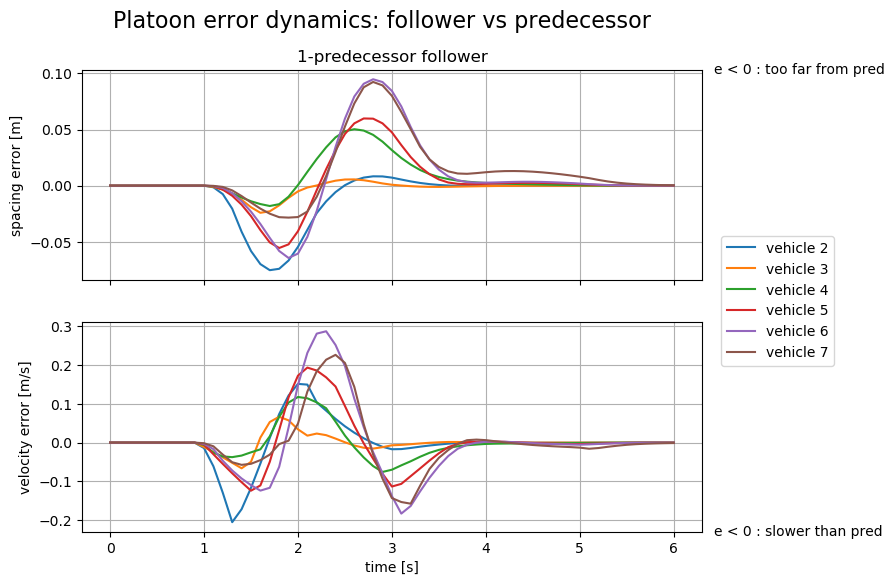

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"{n_pred}-predecessor follower")
fig.subplots_adjust(top=0.88)

for i in range(2, N+1):
    ax[0].plot(t_range[:T-H], d_error[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")